Upload Crop_recommendation.csv:


Saving Crop_recommendation.csv to Crop_recommendation (1).csv
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 200}
R² = 0.9976
MSE = 0.5754


[07:46:26] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 94%|=================== | 2079/2200 [00:16<00:00]       

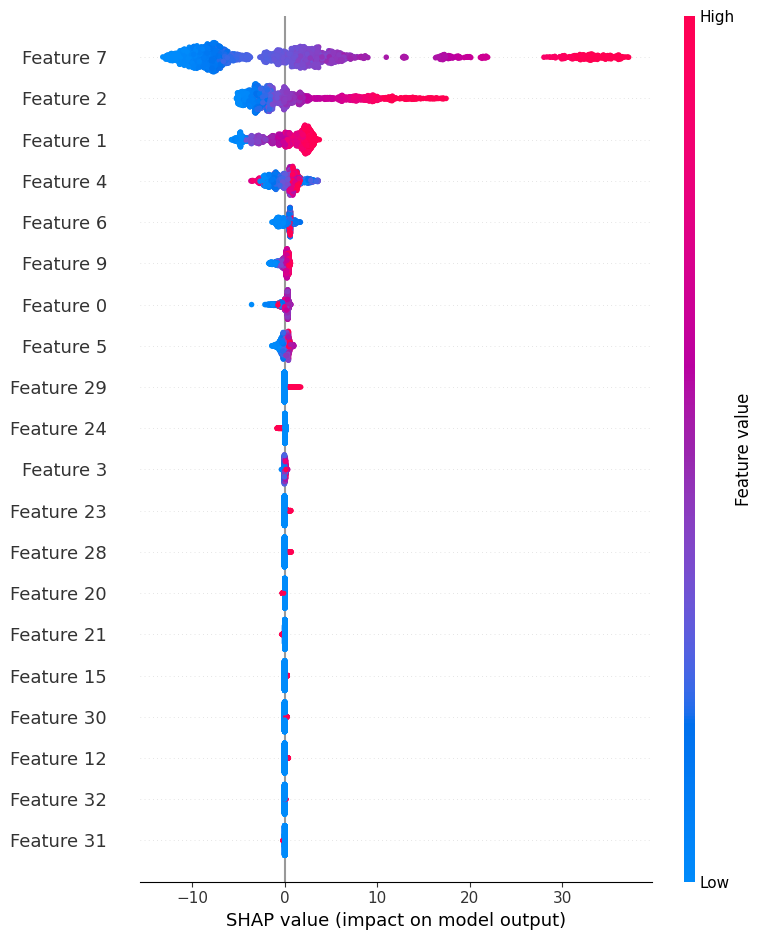

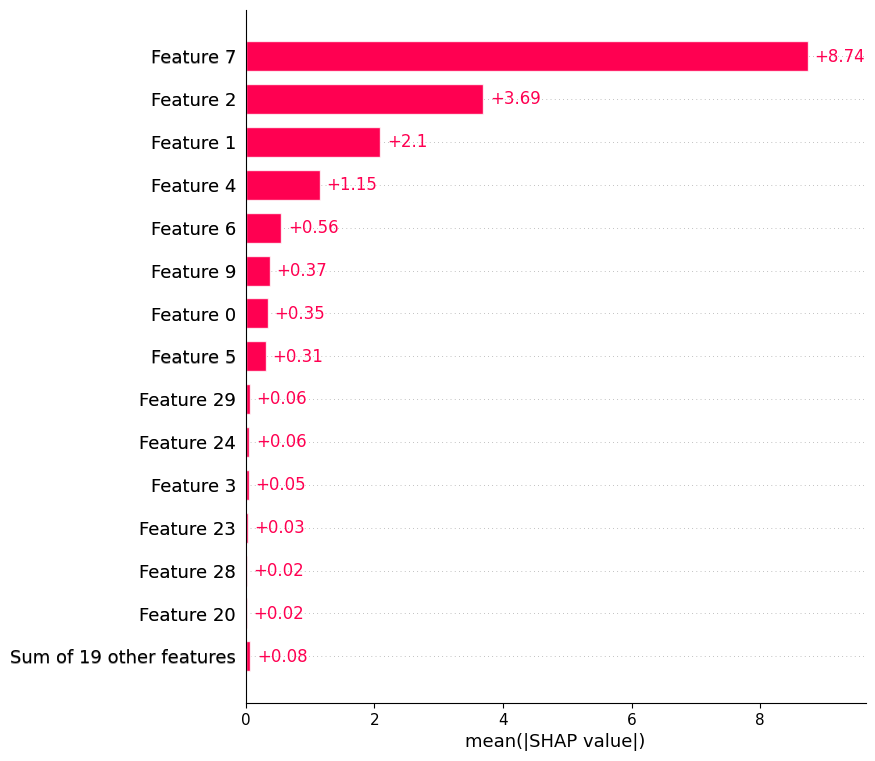

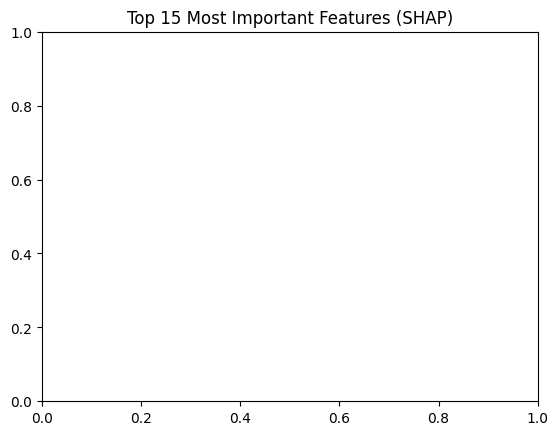

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Temparature,Humidity,Rainfall,pH,Nitrogen,Phosphorous,Potassium,Crop_Type,NPK_Avg,Total_Nutrients,Temp_Humidity_Index,Moisture_norm,Expected_yield,Fertility_level,Soil_cover_condition
0,20.879744,82.002744,202.935536,6.502985,90,42,43,rice,58.333333,175,17.121963,0.656458,69.931854,High,Dense
1,21.770462,80.319644,226.655537,7.038096,85,58,41,rice,61.333333,184,17.485957,0.741675,73.816544,High,Dense
2,23.004459,82.320763,263.964248,7.840207,60,55,44,rice,53.000000,159,18.937446,0.875710,73.937500,Medium,Dense
3,26.491096,80.158363,242.864034,6.980401,74,35,40,rice,49.666667,149,21.234829,0.799905,69.768166,Medium,Dense
4,20.130175,81.604873,262.717340,7.628473,78,42,42,rice,54.000000,162,16.427204,0.871231,73.267593,Medium,Dense


In [1]:
!pip install shap==0.43.0 xgboost==2.0.3 scikit-learn==1.3.2

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
from google.colab import files
import io
import shap
import matplotlib.pyplot as plt

########################
# 1) Upload CSV
########################
print("Upload Crop_recommendation.csv:")
uploaded = files.upload()

if "Crop_recommendation.csv" in uploaded:
    df = pd.read_csv(io.BytesIO(uploaded["Crop_recommendation.csv"]))
else:
    first_file = next(iter(uploaded))
    df = pd.read_csv(io.BytesIO(uploaded[first_file]))

df.columns = [c.strip().replace(" ", "_") for c in df.columns]

########################
# 2) Rename Columns
########################
rename_map = {
    "N": "Nitrogen",
    "P": "Phosphorous",
    "K": "Potassium",
    "temperature": "Temparature",
    "humidity": "Humidity",
    "rainfall": "Rainfall",
    "ph": "pH",
    "label": "Crop_Type"
}
df.rename(columns=rename_map, inplace=True)

########################
# 3) Feature Engineering
########################
num_cols = ["Temparature", "Humidity", "Rainfall", "pH", "Nitrogen", "Phosphorous", "Potassium"]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Derived features
df["NPK_Avg"] = (df["Nitrogen"] + df["Phosphorous"] + df["Potassium"]) / 3
df["Total_Nutrients"] = df["Nitrogen"] + df["Phosphorous"] + df["Potassium"]
df["Temp_Humidity_Index"] = df["Temparature"] * df["Humidity"] / 100
df["Moisture_norm"] = (df["Rainfall"] - df["Rainfall"].min()) / (df["Rainfall"].max() - df["Rainfall"].min())

# Fertility level
q1, q2 = df["Total_Nutrients"].quantile([0.33, 0.66])
def fertility_label(x):
    if x <= q1: return "Low"
    elif x <= q2: return "Medium"
    else: return "High"
df["Fertility_level"] = df["Total_Nutrients"].apply(fertility_label)

# Soil cover condition
df["Cover_score"] = 0.6 * df["Humidity"] + 0.4 * df["Rainfall"]
c1, c2 = df["Cover_score"].quantile([0.33, 0.66])
def cover_label(x):
    if x <= c1: return "Sparse"
    elif x <= c2: return "Moderate"
    else: return "Dense"
df["Soil_cover_condition"] = df["Cover_score"].apply(cover_label)

########################
# 4) Synthetic Yield Target
########################
ideal_temp = 27.0
temp_factor = np.maximum(0, 1 - (np.abs(df["Temparature"] - ideal_temp)/(ideal_temp+1)))
df["synthetic_yield_target"] = (
    0.5 * df["NPK_Avg"] +
    0.2 * df["Humidity"] +
    0.1 * df["Rainfall"] +
    5.0 * temp_factor
)
target = "synthetic_yield_target"

########################
# 5) Model Setup
########################
features = ["Temparature", "Humidity", "Rainfall", "pH",
            "Nitrogen", "Phosphorous", "Potassium",
            "NPK_Avg", "Total_Nutrients",
            "Temp_Humidity_Index", "Moisture_norm"]
cat_cols = ["Crop_Type"]

X = df[features + cat_cols]
y = df[target]

numeric_transformer = Pipeline([('scaler', StandardScaler())])
categorical_transformer = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = make_column_transformer(
    (numeric_transformer, features),
    (categorical_transformer, cat_cols),
    remainder='drop'
)

xgb_model = XGBRegressor(random_state=42)

pipeline = Pipeline([('preproc', preprocessor), ('xgb', xgb_model)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

########################
# 6) Hyperparameter Tuning
########################
param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__learning_rate': [0.05, 0.1],
    'xgb__max_depth': [3, 5]
}
grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='r2', verbose=1)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)

########################
# 7) Predictions & Evaluation
########################
df["Expected_yield"] = grid.predict(X)
y_pred_test = grid.predict(X_test)

print(f"R² = {r2_score(y_test, y_pred_test):.4f}")
print(f"MSE = {mean_squared_error(y_test, y_pred_test):.4f}")

########################
# 8) SHAP Feature Importance (Fixed)
########################
X_transformed = preprocessor.fit_transform(X)
explainer = shap.Explainer(grid.best_estimator_.named_steps['xgb'], X_transformed)
shap_values = explainer(X_transformed)

# SHAP summary plot (auto handles feature names)
shap.summary_plot(shap_values, show=True)

# Optional: Bar chart of top features
shap.plots.bar(shap_values, max_display=15)
plt.title("Top 15 Most Important Features (SHAP)")
plt.show()

########################
# 9) Save Final Output
########################
final_cols = [
    "Temparature", "Humidity", "Rainfall", "pH",
    "Nitrogen", "Phosphorous", "Potassium", "Crop_Type",
    "NPK_Avg", "Total_Nutrients", "Temp_Humidity_Index", "Moisture_norm",
    "Expected_yield", "Fertility_level", "Soil_cover_condition"
]

final_df = df[final_cols]
out_name = "Crop_recommendation_with_predictions.csv"
final_df.to_csv(out_name, index=False)
files.download(out_name)

final_df.head()